## Imports

In [60]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from pandas import DataFrame
import pickle
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# RF
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Over-sampling for imbalance problem
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

## Pre-process data

In [62]:
os.chdir('/Users/hadi/Documents/Professional_development/DS/INSIGHT/Project/Data/Data_pro')
raw_data=pd.read_csv('Data_All_sorted_alpha_MVP_V6.csv')

#raw_data.index = raw_data.Neighbourhood

Y = pd.DataFrame(raw_data['Future_change_low_income_pop'])
Y=Y*100

# Features selections

# options -: All fesstures:
# X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
#                            'Change in low income pop','Total Area','Total Population',\
#                            'Pop  25 - 34 years','Recent Immigrants','TTC Stops','Health Providers','Businesses',\
#                            'Social Housing Units','Rent Bank Applicants']])

# options -2: High correlation features
X = pd.DataFrame(raw_data[['Home price','Change in housing pricing','Low income population',\
                             'Change in low income pop','Total Population',\
                             'Pop  25 - 34 years','TTC Stops','Health Providers','Businesses',\
                             'Social Housing Units']])

# options -3: Highest correlation features
# X = pd.DataFrame(raw_data[['Change in low income pop',\
#                            'Pop  25 - 34 years','Businesses',\
#                            'Social Housing Units']])

# Resampling for imbalance
X_resampled, y_resampled = SMOTE().fit_resample(X, Y)
#print(sorted(Counter(y_resampled).items()))

#Split Test Train Data
    #if original data:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 44)

    #if resampled data:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size = 0.1, random_state = 44)


# #Method -2 : Stratified
# split = StratifiedShuffleSplit(n_splits=1, test_size=.15, random_state=44) # split is to classify for stratify
# for train_index, test_index in split.split(raw_data, raw_data[['Label']]):  # column to use to stratify
#     X_train = X.loc[train_index]
#     X_test = X.loc[test_index]
#     Y_train = Y.loc[train_index]
#     Y_test = Y.loc[test_index]

#Standardize the Data:
#X_train = pd.DataFrame(StandardScaler().fit_transform(X_train)) 
#X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))

/anaconda3/lib/python3.7/site-packages/imblearn/utils/_validation.py:93: UserWarning: 'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got continuous instead.
  TARGET_KIND, type_of_target(y)))
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Modeling

In [63]:
# Random Forest Modelling 

gsc = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': range(4,8,14),
        'n_estimators': (10, 50, 100),
    }, cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, Y_train)
best_params = grid_result.best_params_
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
scores = cross_val_score(rfr, X_train, Y_train, cv=10, scoring='neg_mean_absolute_error')
print(scores)
model_RF=rfr.fit(X_train, Y_train)

# save the model to disk
predictive_Reg_model_RF = 'finalized_Reg_model_RF.sav'
pickle.dump(rfr, open(predictive_Reg_model_RF, 'wb'))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[ -4.44770092  -7.66366994  -5.84644011  -7.23866293  -8.87909061
 -10.45541361  -5.88257994  -8.91462879  -4.85683763  -5.89993552]


## Predictions

In [64]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# load the model from disk
loaded_model = pickle.load(open('finalized_Reg_model_RF.sav', 'rb'))
y_pred_RF= loaded_model.predict(X_test)

y_pred_RF= loaded_model.predict(X_test)
y_pred_train_RF=loaded_model.predict(X_train)

Error = np.abs(Y_test - y_pred_RF)#/np.abs(Y_test)
print("Error : in "+str(np.mean(Error)))

rms_RFR = np.sqrt(mean_squared_error(Y_test, y_pred_RF))
print("RMS ="+str(rms_RFR))

rr_TRAIN = metrics.r2_score(Y_train, y_pred_train_RF)
rr_TRAIN = round(rr_TRAIN,2)
print("R-Squared-TRAIN ="+str(rr_TRAIN))

rr_TEST = metrics.r2_score(Y_test, y_pred_RF)
rr_TEST = round(rr_TEST,2)
print("R-Squared-TEST ="+str(rr_TEST))

Error : in 7.845322840534893
RMS =13.510920865305723
R-Squared-TRAIN =0.64
R-Squared-TEST =0.73


## Visualisation

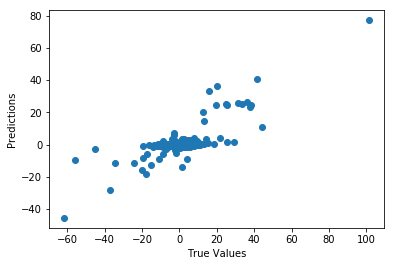

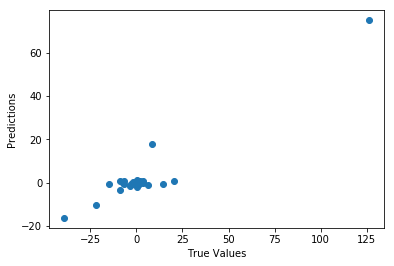

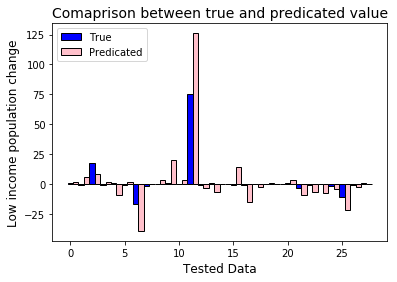

In [59]:
## The line / model
plt.scatter(Y_train, y_pred_train_RF)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.show()

plt.scatter(Y_test, y_pred_RF)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.show()

y_pred_RF_4plt = pd.DataFrame(y_pred_RF.tolist())
y_pred_RF_4plt.columns = ['Future_change_low_income_pop']

y_test_4plt = pd.DataFrame(Y_test.tolist())
#df['Future_change_low_income_pop'] = pd.DataFrame(y_pred_lm)
y_test_4plt.columns = ['Future_change_low_income_pop']

Data_list=['Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data'\
      ,'Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data','Data'\
          ,'Data','Data']
Coparison=['True','Predicated']
pos = np.arange(len(Data_list))
bar_width = 0.5
PredictoinValues=y_pred_RF_4plt['Future_change_low_income_pop'] #[60,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,40,70,65,85,90,100,100]
TestValues=y_test_4plt['Future_change_low_income_pop'] #[30,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,60,70,55,75,90,20,33]


plt.bar(pos,PredictoinValues,bar_width,color='blue',edgecolor='black')
plt.bar(pos+bar_width,TestValues,bar_width,color='pink',edgecolor='black')
plt.xlabel('Tested Data', fontsize=12)
plt.ylabel('Low income population change', fontsize=12)
plt.title('Comaprison between true and predicated value',fontsize=14)
plt.legend(Coparison,loc=2)
plt.show()


In [32]:
best_params

{'max_depth': 4, 'n_estimators': 50}

## Plot Train and Test Data Together

Text(0.5, 1.0, 'Predicted Vs. Actual')

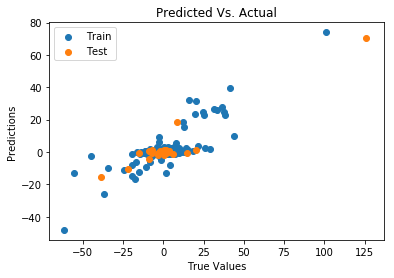

In [86]:
color = ("blue", "yellow")

plt.scatter(Y_train, y_pred_train_RF, label="Train")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')

plt.scatter(Y_test, y_pred_RF, label="Test")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('testplot.png')
plt.legend(loc=2)
plt.title('Predicted Vs. Actual')

In [75]:
model_RF.feature_importances_

array([0.04778754, 0.04121307, 0.01403957, 0.4308521 , 0.01850153,
       0.04194428, 0.03425305, 0.02018986, 0.24822247, 0.10299654])